In [1]:
#input_address = input('Input image address:') #input must be in "" ("test.jpg" if file is in project folder),
                                              #acceptable formats: .jpg, .jpeg, .png, .gif, .bmp
input_address = 'test.png'

In [2]:
#INTERFACE
#Modes
#http://www.hackerfactor.com/blog/index.php?/archives/529-Kind-of-Like-That.html 
#dhash_mode recommended
ahash_mode  = 0 #compare ahashes
phash_mode  = 0 #compare phashes
dhash_mode  = 0 #compare dhashes
ncc_mode    = 1 #find normalized cross correlation

pix_mode    = 0 #compare per-pixel (FOR TESTS ONLY)
                #Quite effectively to a binary image. 
                #To grayscale need to use something to check the value of pixels rather than quantity. 
                #Perhaps: Levenshtein distance, MSE, RMSE, etc.

#Options
threshold   = 1    #pixels needed for symbol detection
t_threshold = 200    #delete found symbol if number of black pixels < threshold
black_mode  = 0     #compare only black pixels
bin_ratio   = 600   #binarization threshold (0-255*3)
resize_mode = 1     #none = 0, antialias = 1, bicubic = 2 (0 IS NOT RECOMMENDED)
basewidth   = 8     #image width after compression (px)
hashing_mode = 'md5'#md5, sha1, sha224, sha256, sha384, sha512

rotate_mode = 0     #comrape with rotated examples (NOT RECOMMENDED)
rotate_degr = 87    #the degree to which the image is rotated by one step, 
                    #it will be approximated to integer number of steps for the passage of a circle.
    
from PIL import Image, ImageDraw
from IPython.display import display, Image as DImage
from numpy import array
import os, scipy.fftpack, numpy, glob, shutil, numpy
#Creating folders
#The folder where the user places the samples to be compared to the incoming image.
#Acceptable formats: .jpg, .jpeg, .png, .gif, .bmp
if not os.path.exists(os.getcwd()+'/examples/'):
    os.mkdir('examples')
examples_path = os.getcwd()+'/examples/'
#The folder in which the binary images will be generated.
if not os.path.exists(os.getcwd()+'/binary/'):
    os.mkdir('binary')
binary_path = os.getcwd()+'/binary/'
#The folder in which the found symbols will be generated.
if not os.path.exists(os.getcwd()+'/found/'):
    os.mkdir('found')
found_path = os.getcwd()+'/found/'
#The subfolders in which the found symbols will be generated.
for d, dirs, files in os.walk(examples_path):
        for f in dirs:
            if not os.path.exists(binary_path+f):
                os.mkdir(binary_path+f)


#Global variables.
names   = []
values  = []
results = []
ahashes = []
phashes = []
dhashes = []
nccors  = []

RESULT = ''

In [3]:
def clean_folders():
    #Cleaning folders
    #The folder in which the binary images will be generated.
    if os.path.exists(os.getcwd()+'/binary/'):   
        shutil.rmtree(os.getcwd()+'/binary/')
    #The folder in which the found symbols will be generated.
    if os.path.exists(os.getcwd()+'/found/'):
        shutil.rmtree(os.getcwd()+'/found/')

In [4]:
def address_helper(input_img_addr, mode):
    if mode == 'png': #after preprocessing the program only works with .png
        input_img_addr = input_img_addr.replace('.jpg','.png')
        input_img_addr = input_img_addr.replace('.jpeg','.png')
        input_img_addr = input_img_addr.replace('.gif','.png')
        input_img_addr = input_img_addr.replace('.bmp','.bmp')
    if mode == 'bin': #change the address of the folder to /binary
        input_img_addr = input_img_addr.replace('/examples/','/binary/')
    if mode == 'cln': #leave only the name of file (letter)
        if rotate_mode == 1:
            for i in range(1, abs(360 / rotate_degr)):
                input_img_addr = input_img_addr.replace(str(360 / abs(360 / rotate_degr)*(i))+'.','.')
        input_img_addr = input_img_addr.replace('.jpg','')
        input_img_addr = input_img_addr.replace('.jpeg','')
        input_img_addr = input_img_addr.replace('.gif','')
        input_img_addr = input_img_addr.replace('.png','')
        input_img_addr = input_img_addr.replace('.bmp','')
        input_img_addr = input_img_addr.replace(binary_path,'')
        input_img_addr = input_img_addr.replace(found_path,'')
    
    return input_img_addr

In [5]:
def binarization(input_img_addr):
    input_image  = Image.open(input_img_addr).convert('RGB') #convert for .gif opening fix
    draw = ImageDraw.Draw(input_image)
     
    for i in range(input_image.size[0]):
        for j in range(input_image.size[1]):
            r, g, b = input_image.getpixel((i,j))
            if (r + g + b > bin_ratio): 
                r, g, b = 255, 255, 255 #draw pixel black
            else:
                r, g, b = 0, 0, 0       #draw pixel white
            draw.point((i, j), (r, g, b))
    del draw
    #save in /binary folder like name.png
    input_img_addr = address_helper(input_img_addr,'png')
    input_image.save(address_helper(input_img_addr,'bin'), "PNG")

In [6]:
def save_rotate(input_img_addr, rotate_degr):  
    input_img_addr = address_helper(input_img_addr,'png')
    #first step out of cycle, becouse of don't want disposable checking in cycle
    (Image.open(input_img_addr).rotate(rotate_degr) #rotate first step
     .save(input_img_addr.replace('.',str(rotate_degr)+'.'), "PNG"))  #save first step
    input_img_addr = input_img_addr.replace('.',str(rotate_degr)+'.') #first step, str(...*(i-1)) returns '0'
    
    for i in range(2, 360 / rotate_degr):
        input_image = Image.open(input_img_addr).rotate(rotate_degr) 
        input_img_addr = input_img_addr.replace(str((rotate_degr)*(i-1))+'.',
                                                str((rotate_degr)*i)+'.')
        input_image.save(input_img_addr, "PNG")

In [7]:
def resize(input_img_addr, basewidth):#preprocessing for hashes
    input_image = Image.open(input_img_addr)
    height = int((float(input_image.size[1]) * 
                 float(basewidth / float(input_image.size[0])))) #calculate the proportional height
    if resize_mode == 1:
        input_image = input_image.resize((basewidth,height), Image.ANTIALIAS)
    if resize_mode == 2:
        input_image = input_image.resize((basewidth,height), Image.BICUBIC)
    else:
        input_image = input_image.resize((basewidth,height))
    input_image.save(address_helper(input_img_addr,'res'), "PNG")

In [8]:
def separation(input_img_addr, threshold):
    x0 = 0
    y0 = 0
    x1 = 0
    y0 = 0

    symbolsx = []
    symbolsy = []

    black    = False
    symbol = False
    
    input_image = Image.open(input_img_addr).convert('L')
    
    for x in xrange(input_image.size[0]):
        for y in xrange(input_image.size[1]):
            pix = input_image.getpixel((x,y))
            if pix < 255:
                black += 1
        if symbol == False and black > threshold: 
            x0 = x
            symbol = True
        if symbol == True and black <= threshold:
            x1 = x
            symbol = False
            symbolsx.append((x0, x1))
        black = 0
    
    black    = False
    symbol = False
        
    for y in xrange(input_image.size[1]):
        for x in xrange(input_image.size[0]):
            pix = input_image.getpixel((x,y))
            if pix < 255:
                black += 1
        if symbol == False and black > threshold:
            y0 = y
            symbol = True
        if symbol == True and black <= threshold:
            y1 = y
            symbol = False
            symbolsy.append((y0, y1))
        black = 0
    
    count = 0
    black = 0
    
    if symbolsx == []:
        symbolsx = [(0,input_image.size[0])] 
    if symbolsy == []:
        symbolsy = [(0,input_image.size[1])] 
        
    for y in symbolsy:
        for x in symbolsx:
            if count < 1000:
                temp = '{:03d}'.format(count)                  
                input_image.crop((x[0],y[0],x[1],y[1])).save('found/'+str(temp)+'.png', "PNG")
            count += 1

In [9]:
def delete_trash(threshold):
    images = os.listdir(found_path)
    for i in range(len(images)):
        try:
            black = 0
            input_image = Image.open(found_path+images[i])
            
            for x in xrange(input_image.size[0]):
                for y in xrange(input_image.size[1]):
                    pix = input_image.getpixel((x,y))
                    if pix != 255:
                        black += 1
            if black < threshold:
                os.remove(found_path+images[i])
        except IOError:
            pass        

In [10]:
def pix_compare(input_img_addr, example_addr):
    input_image = Image.open(input_img_addr)
    input_pixels = input_image.load()
    example = Image.open(example_addr).resize((input_image.size[0],input_image.size[1]), Image.ANTIALIAS)
    true = 0 #number of equal pixels
    
    for i in range(0, input_image.size[0]):
        for j in range(0, input_image.size[1]):
            input_pixel = input_image.getpixel((i, j))
            example_pixel = example.getpixel((i, j))
            if input_pixel == example_pixel:                        
                if not (black_mode == 1 and input_pixels[i, j][0] == 0):
                    true+=1  
    return true

In [11]:
def ncc(input_img_addr, example_addr):
    #based on syntacticbayleaves.com/2008/12/03/determining-image-similarity/  
    input_image = Image.open(input_img_addr)
    example = Image.open(example_addr).resize((input_image.size[0],input_image.size[1]), Image.ANTIALIAS)
    
    images = [input_image, example]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel in image.getdata():
            vector.append(numpy.mean(pixel))
        vectors.append(vector)
        norms.append(numpy.linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    res = numpy.dot(a / a_norm, b / b_norm)
    return res

In [12]:
def ham_dist(input_img_hash, example_hash):
    distance = 0
    #compare character by character
    for input_char, example_char in zip(input_img_hash, example_hash):
        if input_char != example_char:
            distance += 1
    return distance

In [13]:
def ahash(input_img_addr):
    #from ImageHash lib
    image = Image.open(input_img_addr).convert('L').resize((basewidth, basewidth))
    pixels = numpy.array(image.getdata()).reshape((basewidth, basewidth))
    avg = pixels.mean()
    diff = ''
    tmp = pixels > avg
    for i in range(0, basewidth-1):
        for j in range(0, basewidth-1):
            if tmp[i,j] == True:
                diff+='1'
            else:
                diff+='0'    
    return diff

In [14]:
def phash(input_img_addr):
    #from ImageHash lib
    image = Image.open(input_img_addr).convert('L').resize((basewidth, basewidth))
    pixels = numpy.array(image.getdata(), dtype = numpy.float).reshape((basewidth, basewidth))
    dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
    dct_low_freq = dct[:basewidth, :basewidth]
    med = numpy.median(dct_low_freq)
    diff = ''
    tmp = dct_low_freq > med
    for i in range(0, basewidth-1):
        for j in range(0, basewidth-1):
            if tmp[i,j] == True:
                diff+='1'
            else:
                diff+='0'    
    return diff

In [15]:
def dhash(input_img_addr):
    #from ImageHash lib
    # resize(w, h), but numpy.array((h, w))
    image = Image.open(input_img_addr).convert('L').resize((basewidth, basewidth))
    pixels = numpy.array(image.getdata(), dtype=numpy.float).reshape((basewidth, basewidth))
    # compute differences between rows
    diff = ''
    tmp = pixels[:, 1:] > pixels[:, :-1]
    for i in range(0, basewidth-1):
        for j in range(0, basewidth-1):
            if tmp[i,j] == True:
                diff+='1'
            else:
                diff+='0'    
    return diff

In [16]:
def compare_1to1(input_img_addr, example_addr):
    #example_addr = binary_path + address_helper(example_addr,'png')
    input_img_addr = found_path + input_img_addr
    naive_cut(input_img_addr)
    
    #compare per-pixel
    if pix_mode == 1:      
        values.append(pix_compare(input_img_addr, example_addr))
        
    #normalized cross correlation
    if ncc_mode == 1:
        nccors.append(ncc(input_img_addr, example_addr))
        
    #compare ahashes
    if ahash_mode == 1:
        ahashes.append(ham_dist(ahash(input_img_addr), ahash(example_addr)))
    #compare phashes
    if phash_mode == 1:
        phashes.append(ham_dist(phash(input_img_addr), phash(example_addr)))
    #compare dhashes
    if dhash_mode == 1:
        dhashes.append(ham_dist(dhash(input_img_addr), dhash(example_addr)))

    
    names.append(address_helper(example_addr, 'cln'))   

In [17]:
def compare_1toN(input_img_addr):
    #delete previous values
    global names, values, ahashes, phashes, dhashes, nccors
    names, values, ahashes, phashes, dhashes, nccors = [],[],[],[],[],[]
    
    examples = []
    for d, dirs, files in os.walk(binary_path):
        for f in files:
            path = os.path.join(d,f)
            examples.append(path)
          
    for i in range(len(examples)):
        try: #check if file is image
            compare_1to1(input_img_addr,examples[i])
        except IOError:
            pass

In [18]:
def result_1toN():#rewrite for top-3 statistics
    global results #local results
    global RESULT  #global result
    results = [] #clean prev result
    
    #collecting all the local results
    if pix_mode == 1 and values != []:
        results.append(names[values.index(max(values))])
    if ahash_mode == 1 and ahashes != []:
        results.append(names[ahashes.index(min(ahashes))])
    if phash_mode == 1 and phashes != []:
        results.append(names[phashes.index(min(phashes))])
    if dhash_mode == 1 and dhashes != []:
        results.append(names[dhashes.index(min(dhashes))])
    if ncc_mode == 1 and nccors != []:
        results.append(names[nccors.index(max(nccors))])
    
    if results == []:
        results = ['']
        
    temp = max(set(results), key=results.count)
    display(DImage(filename=binary_path+temp+'.png'))
    for d, dirs, files in os.walk(examples_path):
        for f in dirs:
            temp = temp.replace(f,'')
            temp = temp.replace('/','')  
    RESULT += temp #add the most likely local result to the global

In [19]:
def print_1toN(): #developer function, NEWER EVER USE TO THE FULL DATASET
    #if pix_mode == 1:
    #    print('Pixel mode:')
    #    for i in range(len(names)):
    #        print(names[i],values[i])
    #if ahash_mode == 1:
    #    print('AHash mode:')
    #    for i in range(len(names)):
    #        print(names[i],ahashes[i])
    #if phash_mode == 1:
    #    print('PHash mode:')
    #    for i in range(len(names)):
    #        print(names[i],phashes[i])
    #if dhash_mode == 1:
    #    print('DHash mode:')
    #    for i in range(len(names)):
    #        print(names[i],dhashes[i])
    #if ncc_mode == 1:
    #    print('NCC mode:')
    #    for i in range(len(names)):
    #        print(names[i],nccors[i])
    print('Results:')
    if pix_mode == 1 and values != []:
        print('Pixel mode:'+str(names[values.index(max(values))]))
    if ahash_mode == 1 and ahashes != []:
        print('AHash mode:'+str(names[ahashes.index(min(ahashes))]))
    if phash_mode == 1 and phashes != []:
        print('PHash mode:'+str(names[phashes.index(min(phashes))]))
    if dhash_mode == 1 and dhashes != []:
        print('DHash mode:'+str(names[dhashes.index(min(dhashes))]))
    if ncc_mode == 1 and nccors != []:
        print('NCC mode:'+str(names[nccors.index(max(nccors))]))
    print('Result:'+str(RESULT))

In [20]:
def naive_cut(img_address):
    img = Image.open(img_address).convert('L')
    arr = array(img)
    norm_arr = []
    find = False

    for c in xrange(4):
        black = 0
        find = False
        img = Image.fromarray(arr)
        for x in xrange(len(arr[:,1])):
            if find:
                break
            for y in xrange(len(arr[1,:])):
                if arr[x,y] == 0:
                    black+=1
            if black >= 1:
                arr = numpy.delete(arr, numpy.s_[0:x], axis=0)
                find = True
                break
        arr = numpy.rot90(arr)
        c+=1
        
    
    img = Image.fromarray(arr)
    img.save(img_address,"PNG")

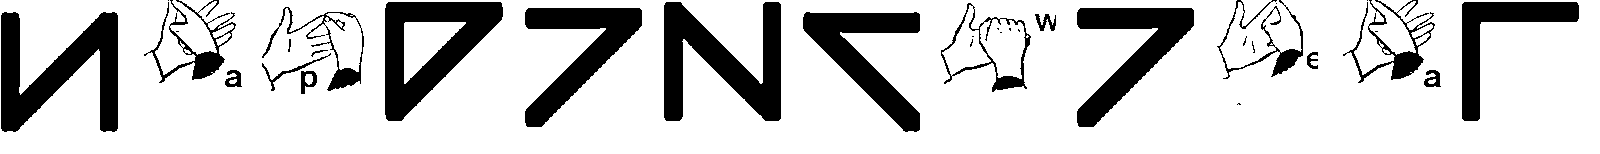

Processing:


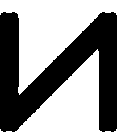

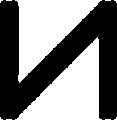

Results:
NCC mode:HVD/h
Result:h
Processed: 1/12
Processing:


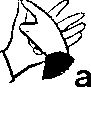

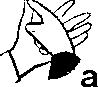

Results:
NCC mode:1/a
Result:ha
Processed: 2/12
Processing:


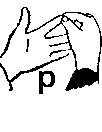

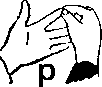

Results:
NCC mode:1/p
Result:hap
Processed: 3/12
Processing:


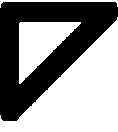

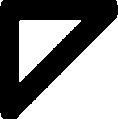

Results:
NCC mode:HVD/p
Result:happ
Processed: 4/12
Processing:


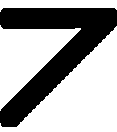

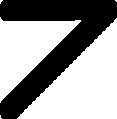

Results:
NCC mode:HVD/y
Result:happy
Processed: 5/12
Processing:


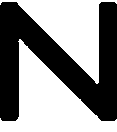

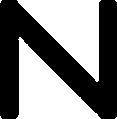

Results:
NCC mode:HVD/n
Result:happyn
Processed: 6/12
Processing:


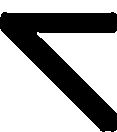

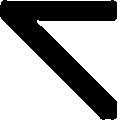

Results:
NCC mode:HVD/e
Result:happyne
Processed: 7/12
Processing:


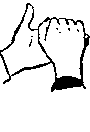

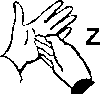

Results:
NCC mode:1/z
Result:happynez
Processed: 8/12
Processing:


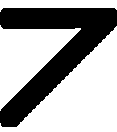

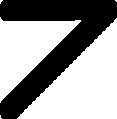

Results:
NCC mode:HVD/y
Result:happynezy
Processed: 9/12
Processing:


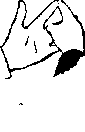

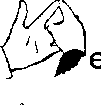

Results:
NCC mode:1/e
Result:happynezye
Processed: 10/12
Processing:


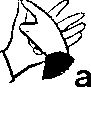

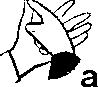

Results:
NCC mode:1/a
Result:happynezyea
Processed: 11/12
Processing:


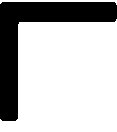

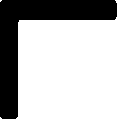

Results:
NCC mode:HVD/r
Result:happynezyear
Processed: 12/12
Message: happynezyear


In [21]:
def main():
    global RESULT, input_address
    display(DImage(filename=input_address))
    binarization(input_address)
    input_address = address_helper(input_address,'png')
    
    examples = []
    for d, dirs, files in os.walk(examples_path):
        for f in files:
            path = os.path.join(d,f)
            examples.append(path)
             
    for i in range(len(examples)):
        try: #check if file is image
            binarization(examples[i])
            naive_cut(address_helper(examples[i], 'bin'))
            if rotate_mode == 1:  
                binaries = os.listdir(examples_path)
                #rotate to the approximate degree
                save_rotate(binary_path+binaries[i],360 / abs(360 / rotate_degr))
        except IOError:
            pass
        
        
    #preprocessing(img).save(input_address)
    separation(input_address, threshold)
    delete_trash(t_threshold)
    symbols = os.listdir(found_path)
    count = 0
    for i in sorted(symbols):
        try: #check if files are images
            count+=1
            print('Processing:')
            display(DImage(filename=found_path+i))
            compare_1toN(i)
            result_1toN()
            print_1toN()
            print('Processed: '+str(count)+'/'+str(len(symbols)))
        except IOError:
            pass
    print('Message: '+RESULT)
    RESULT = ''
    clean_folders()
main()